In [551]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [552]:
""" 
the spaced repetition half-liferegression is based on two formulas : 
p_recall = 2 ** (-d / h)
h = 2 ** (theta * x)U
the objective of this regression is to determine theta
we will utilise two python ml linear regression libraries: sklearn and pytorch
we will use data from the duolingo dataset, which consists of 13 million records 
"""

' \nthe spaced repetition half-liferegression is based on two formulas : \np_recall = 2 ** (-d / h)\nh = 2 ** (theta * x)U\nthe objective of this regression is to determine theta\nwe will utilise two python ml linear regression libraries: sklearn and pytorch\nwe will use data from the duolingo dataset, which consists of 13 million records \n'

# Utils

In [553]:
def h_truth_calculator (delta, p_recall):
    h_truth = - delta / np.log2(p_recall)
    return h_truth

def p_pred_calculator (delta, h):
  p_pred = torch.tensor(2.0).pow (- delta/ h)
  epsilon = torch.tensor(1e-5)
  p_pred = torch.clamp(p_pred, min = epsilon, max = 1 - epsilon)
  return p_pred
def p_WMSEloss (y_true, y_pred):
  weight = torch.where(y_true < 0.9, torch.tensor(4.0), torch.tensor(1.0))
  loss = weight * (y_true - y_pred) **2
  return torch.mean(loss)
def h_WMSEloss (y_true, y_pred):
  
  loss = (y_true - y_pred) **2
  return torch.mean(loss)


# Data Preprocessing

## upload data

In [554]:
r = 0
df = pd.read_csv("/Users/nasser/Downloads/learning_traces.13m.csv", skiprows = lambda i : i > 0 and np.random.randint(100) > r )


In [555]:
# half-life = X (features) * theta (weights)  
# we will use history_seen and history_correct as features
# we will use deltta and p recall to estimate half-life truth using the formula, h = -delta / log2 (p_recall)

In [556]:
df['delta'] = df['delta']/ (24 * 60 * 60) # delta units converted to days
epsilon = 1e-5
df['p_recall']= np.clip(df['p_recall'] ,epsilon, 1 - epsilon ) # a small constant added or subtracted to p recall for stability
df['h'] = df.apply(lambda row : h_truth_calculator(row['delta'], row['p_recall']), axis = 1) 

In [557]:
df = df[['history_seen', 'history_correct', 'delta', 'h', 'p_recall']]
df.describe()

,history_seen,history_correct,delta,h,p_recall
count,128845.000000,128845.000000,128845.000000,1.288450e+05,128845.000000
mean,22.954643,20.226016,8.503660,4.717530e+05,0.896512
std,165.503703,147.957238,26.140038,1.601195e+06,0.270684
min,1.000000,1.000000,0.000012,6.968287e-07,0.000010
25%,3.000000,3.000000,0.006123,1.797039e+02,0.999990
50%,6.000000,6.000000,0.892616,3.746506e+03,0.999990
75%,15.000000,13.000000,5.195926,2.517796e+05,0.999990
max,13483.000000,12855.000000,460.165567,3.189609e+07,0.999990


In [558]:

min_hlife = 0.1 # apx 15 minutes
max_hlife = 274. # 9 months

df= df[df['h']< max_hlife] # maximum h 
df = df[df['h']> min_hlife] # minimum h 
df.describe()

,history_seen,history_correct,delta,h,p_recall
count,32006.000000,32006.000000,32006.000000,32006.000000,32006.000000
mean,26.573018,23.632444,5.884955,110.679647,0.782782
std,166.700813,151.205759,21.331034,89.180705,0.346616
min,1.000000,1.000000,0.000012,0.100116,0.000010
25%,4.000000,3.000000,0.002118,6.577801,0.666667
50%,7.000000,7.000000,0.003183,119.535201,0.999990
75%,17.000000,15.000000,2.654708,185.319674,0.999990
max,13413.000000,12791.000000,350.510162,273.567137,0.999990


## feature engineering

In [559]:
scaled = boxcox (df.values, lmbda = 0.1)
scaled_df = pd.DataFrame(scaled, columns = df.columns)
normalised = MinMaxScaler().fit_transform(df)
normalised_df = pd.DataFrame(normalised, columns = df.columns)

# regression with Sklearn


In [560]:
X_train, X_test, y_train, y_test = train_test_split(df[['history_seen', 'history_correct']], df['h'], test_size =0.2, random_state = 30)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(scaled_df[['history_seen', 'history_correct']], scaled_df['h'], test_size =0.2, random_state = 30)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(normalised_df[['history_seen', 'history_correct']], normalised_df['h'], test_size =0.2, random_state = 30)


In [561]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

model_n = LinearRegression()
model_n.fit(X_train_n, y_train_n)
y_pred_n= model_n.predict(X_test_n)

model_l = LinearRegression()
model_l.fit(X_train_log, y_train_log)
y_pred_l= model_l.predict(X_test_log)

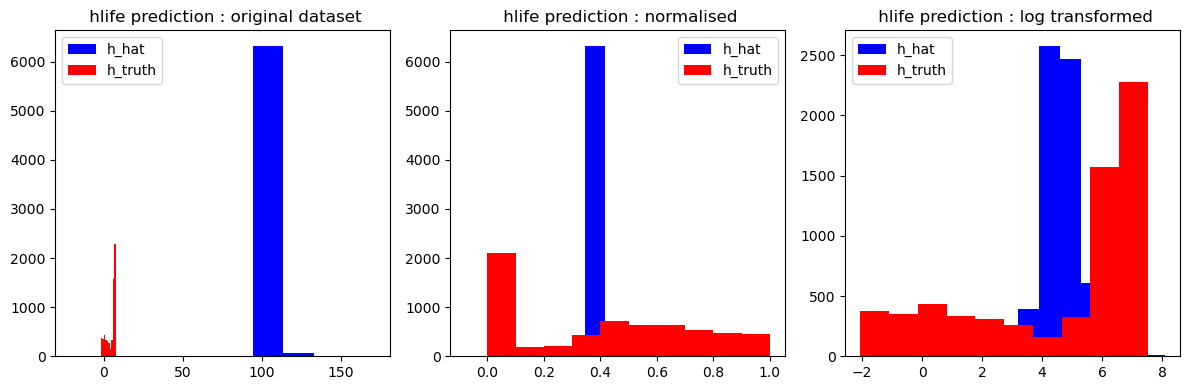

In [562]:
plt.figsize= (5,4)
fig, axes = plt.subplots(1,3, figsize = (12,4))

axes[0].hist(y_pred, color = 'blue', label = 'h_hat' )
axes [0].hist(y_test_log, color = 'red', label = 'h_truth' )
axes[0].set_title (" hlife prediction : original dataset")
axes[0].legend()
axes[1].hist(y_pred_n, color = 'blue', label = 'h_hat' )
axes [1].hist(y_test_n, color = 'red', label = 'h_truth' )
axes[1].set_title (" hlife prediction : normalised")
axes[1].legend()
axes[2].hist(y_pred_l, color = 'blue', label = 'h_hat' )
axes [2].hist(y_test_log, color = 'red', label = 'h_truth' )
axes[2].set_title (" hlife prediction : log transformed")
axes[2].legend()
plt.tight_layout()
plt.show()

# Regression with Torch

## regression model

In [563]:
class TwoStagedModel(nn.Module):
  def __init__(self,alpha = 0.5, lmbda = 0.001, h_loss = h_WMSEloss, p_loss = p_WMSEloss):
    super().__init__()
    self.fc1 = nn.Linear(2,8, bias = False)
    self.fc2 = nn.Linear(8,1)
    self.alpha = alpha
    self.lmbda = lmbda
    self.hloss = h_loss
    self.ploss = p_loss
  def forward (self, x):
    h_pred = self.fc1 (x)
    h_pred = self.fc2(h_pred)
    h_pred = torch.clamp(h_pred, min = 0.001)
    return h_pred

  def p_prediction (self, data, delta, h, p):
    h_pred = self.forward(data)
    h_pred = h_pred.squeeze()
    loss_h = self.hloss(h_pred, h)
    p_pred = p_pred_calculator(delta, h_pred)
    loss_p = self.ploss(p_pred, p)
    regularisation = sum(param.pow(2).sum() for param in self.parameters())
    loss_total = loss_p + loss_h * self.alpha  + self.lmbda * regularisation
    return loss_total

## torch training and test datasets


In [564]:
class CustomDataset(Dataset):
  def __init__(self, delta, data, h, p):
    super(). __init__()
    self.delta = torch.tensor(delta.values, dtype = torch.float32)
    self.data = torch.tensor(data.values, dtype = torch.float32)
    self.labels = torch.tensor(h.values, dtype = torch.float32)
    self.p = torch.tensor(p.values, dtype = torch.float32)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    delta = self.delta[idx]
    data = self.data[idx]
    h = self.labels[idx]
    p = self.p[idx]
    return delta, data, h,p

In [565]:
# original
X2_train, X2_test, delta2_train, delta2_test, y2_train, y2_test, p2_train, p2_test = train_test_split(df[['history_seen', 'history_correct']], df['delta'], df['h'], df['p_recall'], test_size =0.2, random_state = 30)
# normalised
#X2_train, X2_test, delta2_train, delta2_test, y2_train, y2_test, p2_train, p2_test = train_test_split(normalised_df[['history_seen', 'history_correct']], normalised_df['delta'], normalised_df['h'], normalised_df['p_recall'], test_size =0.2, random_state = 30)
# scaled
#X2_train, X2_test, delta2_train, delta2_test, y2_train, y2_test, p2_train, p2_test = train_test_split(scaled_df[['history_seen', 'history_correct']], scaled_df['delta'], scaled_df['h'], scaled_df['p_recall'], test_size =0.2, random_state = 30)

In [566]:
training_data = CustomDataset(delta = delta2_train, data = X2_train, h = y2_train, p = p2_train)
dataloader = DataLoader(training_data, batch_size = 1000, shuffle = True)
test_data = CustomDataset(delta = delta2_test, data = X2_test, h = y2_test, p = p2_test)
test_dataloader = DataLoader(test_data, batch_size = 1000, shuffle = True)

## training

In [567]:
model2 = TwoStagedModel()
optimizer = optim.Adam(model2.parameters(), lr = 0.01)
epoch_size = 30
alpha = 0.5
lmbda = 0.1


model2.train()
for epoch in range (epoch_size):
  epoch_loss = 0
  batch_count = 0



  for delta, data, h, p in dataloader:

    optimizer.zero_grad()

    loss_total = model2.p_prediction(data, delta, h, p)
   

    loss_total.backward()
    optimizer.step()

    batch_count += 1
    epoch_loss += loss_total.item()
  print(f"epoch loss avg {epoch + 1}/ {epoch_size} : {epoch_loss / batch_count :.4f}")

epoch loss avg 1/ 30 : 10091.2344
epoch loss avg 2/ 30 : 10095.7203
epoch loss avg 3/ 30 : 9945.9432
epoch loss avg 4/ 30 : 9844.3524
epoch loss avg 5/ 30 : 9876.3653
epoch loss avg 6/ 30 : 9792.4423
epoch loss avg 7/ 30 : 9753.1631
epoch loss avg 8/ 30 : 9704.6553
epoch loss avg 9/ 30 : 9680.3367
epoch loss avg 10/ 30 : 9650.1236
epoch loss avg 11/ 30 : 9618.2032
epoch loss avg 12/ 30 : 9688.0637
epoch loss avg 13/ 30 : 9602.7907
epoch loss avg 14/ 30 : 9555.2209
epoch loss avg 15/ 30 : 9539.1335
epoch loss avg 16/ 30 : 9515.6771
epoch loss avg 17/ 30 : 9465.8555
epoch loss avg 18/ 30 : 9427.0022
epoch loss avg 19/ 30 : 9395.5401
epoch loss avg 20/ 30 : 9400.7303
epoch loss avg 21/ 30 : 9348.3762
epoch loss avg 22/ 30 : 9332.0858
epoch loss avg 23/ 30 : 9298.3784
epoch loss avg 24/ 30 : 9249.5307
epoch loss avg 25/ 30 : 9260.2511
epoch loss avg 26/ 30 : 9224.3811
epoch loss avg 27/ 30 : 9192.1096
epoch loss avg 28/ 30 : 9190.3089
epoch loss avg 29/ 30 : 9149.5851
epoch loss avg 30/ 30

## evaluation

In [568]:
model2. eval()

p_pred_list = []
p_true_list = []
h_pred_list = []
h_truth_list = []
#for i in range (epoch_size):
for delta2, data2, h2, p2 in test_dataloader:
  h_pred = model2.forward(data2)
  h_pred2 = h_pred.squeeze()
  h_pred_list.extend(h_pred2.detach().numpy())
  h_truth_list.extend(h2.detach().numpy())
  p_pred2 = p_pred_calculator(delta2, h_pred2)
  p_pred_list.extend(p_pred2.detach().numpy())
  p_true_list.extend(p2.detach().numpy())


In [569]:
p_pred_list = np.array(p_pred_list)
p_true_list = np.array(p_true_list)
rscore2 = r2_score(p_true_list, p_pred_list)
rscore2

0.44383814148916556

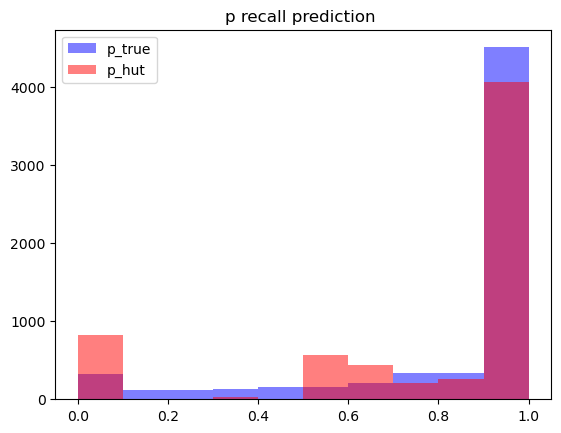

In [570]:
plt.hist(p_pred_list, color = 'blue',  label = 'p_true', alpha = 0.5)
plt.hist(p_true_list, color = 'red',  label = 'p_hut', alpha = 0.5)
plt.title ('p recall prediction ')
plt.legend()
plt.show()